# Recurrent Neural Networks

### Practical Session

<br/> Prof. Dr. Georgios K. Ouzounis
<br/> email: georgios.ouzounis@go.kauko.lt

## Contents

1. Data loading and pre-processing
2. Building the RNN
3. Train and deploy the RNN
4. Improving the RNN

## Challenge

<img src="https://www.sapientrade.com/images/2017/02/14/AI-Machine-Learning-Trading-Benefits.jpg" width="800" align="left"/>

Given a 5-year history of the Google Stock prices predict the stock values for the period of the recent most month that are not included in the historical data.

## Data loading and pre-processing

### Download the data-sets

The data-sets are two comma-separated values files (CSV) and contain a data table of 1258 records for training and a table of 21 records for testing.

They can be found at the [Kaggle.com website](https://www.kaggle.com/akram24/google-stock-price-train) or at various web locations after searching for the filenames: 

**Google_Stock_Price_Test.csv** and **Google_Stock_Price_Train.csv**

Known alternative location: Github user [pdway53](https://github.com/pdway53/Predict_Google_Stock_Price_RNN) 

Open a terminal and use the wget command to get it of the selected location. Example:

```shell
wget https://raw.githubusercontent.com/pdway53/Predict_Google_Stock_Price_RNN/master/Google_Stock_Price_Test.csv

wget https://raw.githubusercontent.com/pdway53/Predict_Google_Stock_Price_RNN/master/Google_Stock_Price_Train.csv 
```


### Import libraries

We need 3 main libraries:

- [Numpy](http://www.numpy.org): it is the fundamental package for scientific computing with Python. It contains among other things a powerful N-dimensional array object that can be used as an efficient multi-dimensional container of generic data. Arbitrary data-types can be defined.
- [matplotlib](https://matplotlib.org):  it is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.
- [pandas](https://pandas.pydata.org): is a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series.

In [1]:
# importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Import the dataset

Dataset description: the open high, low and close values of the Google Stock from 2012 to 2016. [Relevant code here](https://github.com/pdway53/Predict_Google_Stock_Price_RNN)


In [3]:
#importing the dataset

# load the file contents 
dataset_train = pd.read_csv('training_data.csv')

In [4]:
dataset_train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-07-01,41.150002,43.810001,41.009998,42.520000,42.520000,5933800
1,2009-07-02,41.330002,42.160000,39.060001,39.689999,39.689999,2730900
2,2009-07-06,39.709999,39.709999,36.919998,37.299999,37.299999,2627800
3,2009-07-07,37.259998,38.740002,36.419998,38.299999,38.299999,2153200
4,2009-07-08,38.000000,38.220001,36.889999,38.209999,38.209999,2341000
...,...,...,...,...,...,...,...
2532,2019-07-24,31.280001,32.380001,30.730000,32.259998,32.259998,462800
2533,2019-07-25,32.160000,32.180000,31.490000,31.719999,31.719999,310900
2534,2019-07-26,31.780001,32.209999,31.350000,32.040001,32.040001,260700
2535,2019-07-29,31.959999,32.020000,31.250000,31.469999,31.469999,291000


In [5]:
# Create a subtable of relevant entries (open values)
# The .values makes this vector a numpy array
training_set = dataset_train.iloc[:, 1:2].values 

In [6]:
training_set

array([[41.150002],
       [41.330002],
       [39.709999],
       ...,
       [31.780001],
       [31.959999],
       [30.82    ]])

Numpy arrays do not support the view() and head() methods. [More on accessing the numpy data](https://jakevdp.github.io/PythonDataScienceHandbook/02.02-the-basics-of-numpy-arrays.html)


### Feature Scaling

Next we need to rescale our data to the range from 0 to 1. 

Feature scaling is essential as discussed if the Features lecture and needs to be applied to both the training and test sets.

It is computed using the ScikitLearn library [MinMaxScaler()](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) which transforms the selected feature by scaling it to a given range. If more than one, this estimator scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one.

In [7]:
# Feature Scaling

# import the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [14]:
# create a scaler instance to rescale all data to the range of 0.0 to 1.0 
sc = MinMaxScaler(feature_range = (0, 1))

In [15]:
# create the actual training set of scaled values
training_set_scaled = sc.fit_transform(training_set)

In [16]:
training_set_scaled

array([[0.54566605],
       [0.54845718],
       [0.52333696],
       ...,
       [0.40037218],
       [0.40316328],
       [0.38548614]])

### Splitting the training set to dependent and independent variables

In [17]:
# Creating a data structure with 90 timesteps and 1 output

# the 90 stock prices in the last 3 months before today
X_train = [] 

In [18]:
training_set_scaled.shape

(2537, 1)

In [19]:
# the stock price today
y_train = [] 

In [20]:
# we start from day 90 because that is the first instance allowing us to 
# go back 90 days
for i in range(90, 1258): 
    # 0 is the column ID, the only column in this case.    
    # put the last 60 days values in one row of X_train
    X_train.append(training_set_scaled[i-90:i, 0]) 
    y_train.append(training_set_scaled[i, 0])


In [21]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [22]:
X_train

array([[0.54566605, 0.54845718, 0.52333696, ..., 0.42208096, 0.46162198,
        0.44208408],
       [0.54845718, 0.52333696, 0.48534656, ..., 0.46162198, 0.44208408,
        0.44394482],
       [0.52333696, 0.48534656, 0.49682124, ..., 0.44208408, 0.44394482,
        0.45247326],
       ...,
       [0.46332767, 0.47123584, 0.46503338, ..., 0.49061869, 0.49852694,
        0.49759653],
       [0.47123584, 0.46503338, 0.48131495, ..., 0.49852694, 0.49759653,
        0.49992251],
       [0.46503338, 0.48131495, 0.47542255, ..., 0.49759653, 0.49992251,
        0.48146999]])

In [23]:
y_train

array([0.44394482, 0.45247326, 0.45697009, ..., 0.49992251, 0.48146999,
       0.48643206])

### Reshaping the Matrix

We need to add a new matrix dimension to accommodate the indicator (predictor). 

NumPy matrices are tensors (3D) and essentially we need to specify that our matrix consists of **60 days** (dimension x) times **total days in data set** (dimension y) times **1 value per matrix cell (scalar)** (dimension z)

If we were to add the stock value of somebody else together with the the past 60 days of Google, we need to change the length of the 3 dimension to  2.  RNN training tables are 3D!!! Read: [Reshaping NumPy Array | Numpy Array Reshape Examples](https://backtobazics.com/python/python-reshaping-numpy-array-examples/)

In [24]:
# Reshaping the data matrix, we retain the 2 original dimensions and add a third of depth=1
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [60]:
X_train

array([[[0.54566605],
        [0.54845718],
        [0.52333696],
        ...,
        [0.42208096],
        [0.46162198],
        [0.44208408]],

       [[0.54845718],
        [0.52333696],
        [0.48534656],
        ...,
        [0.46162198],
        [0.44208408],
        [0.44394482]],

       [[0.52333696],
        [0.48534656],
        [0.49682124],
        ...,
        [0.44208408],
        [0.44394482],
        [0.45247326]],

       ...,

       [[0.46332767],
        [0.47123584],
        [0.46503338],
        ...,
        [0.49061869],
        [0.49852694],
        [0.49759653]],

       [[0.47123584],
        [0.46503338],
        [0.48131495],
        ...,
        [0.49852694],
        [0.49759653],
        [0.49992251]],

       [[0.46503338],
        [0.48131495],
        [0.47542255],
        ...,
        [0.49759653],
        [0.49992251],
        [0.48146999]]])

## Building the RNN

### RNN initialization

- Import the sequential model from the Keras API;
- Import the Dense layer template from the Keras API;
- Import the LSTM model from the Keras API
- Create an instance of the sequential model called regressor because we want to predict a continuous value

In [61]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [62]:
# Initialising the RNN as a sequence of layers
regressor = Sequential()

### Add First Layer

We first add an object of the LSTM class! 

- The first argument is the number of units or LSTM memory cells. Include many neurons to address the high dimensionality of the problem; say 50 neurons! 
- Second arg: return sequences = true; stacked LSTM !
- Third arg: input 3D shape: observations vs time steps vs number of indicators

In [63]:
# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape =  (X_train.shape[1], 1)))

In [64]:
# the argument is the dropout rate to ignore in the layers (20%), 
# i.e. 50 units * 20% = 10 units will be dropped each time
regressor.add(Dropout(0.2))


### Add More Layers

We can add more LSTM layers but along with Dropout regularization to make sure we avoid overfitting! 

We don’t need to add the shape of the layer again because it is recognized automatically from the number of input units.

The last layer does not return a sequence but connected directly to a fully connected output layer.


In [65]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [66]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [67]:
# Adding a fourth LSTM layer and some Dropout regularisation
# we removed the return_sequences because we no longer return a 
# sequence but a value instead
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Add Output Layer & Compile

The output has 1 dimension , i.e. one value to be predicted thus or output fully connected layer has dimensionality = 1.

- **Optimizer**: rmsprop is recommended in the Keras documentation. The Adam optimizer is also a powerful choice.
- **Loss function**: regression problems take the mean square error as most common

In [68]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [69]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Train and deploy the RNN

### Fit the RNN to the Training set

We now want to train our RNN using the data in our **Training Set X** and **predictors in y** (ground truth in this case). Parameters that can be specified are the:

- **Batch size**:  update the cell weights not on every stock price on every batch_size values; 
- **Number of epochs**: how many iterations to be used, i.e. number of forward and backward propagations for the update of the weights


In [71]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
37/37 [==============================] - 7s 195ms/step - loss: 0.0184
Epoch 2/100
37/37 [==============================] - 7s 193ms/step - loss: 0.0075
Epoch 3/100
37/37 [==============================] - 7s 188ms/step - loss: 0.0066
Epoch 4/100
37/37 [==============================] - 7s 182ms/step - loss: 0.0066
Epoch 5/100
37/37 [==============================] - 7s 178ms/step - loss: 0.0064
Epoch 6/100
37/37 [==============================] - 7s 190ms/step - loss: 0.0057
Epoch 7/100
37/37 [==============================] - 7s 179ms/step - loss: 0.0054
Epoch 8/100
37/37 [==============================] - 7s 177ms/step - loss: 0.0050
Epoch 9/100
37/37 [==============================] - 7s 184ms/step - loss: 0.0047
Epoch 10/100
37/37 [==============================] - 6s 175ms/step - loss: 0.0044
Epoch 11/100
37/37 [==============================] - 7s 192ms/step - loss: 0.0043
Epoch 12/100
37/37 [==============================] - 7s 187ms/step - loss: 0.0049
Epoch 13/100


### Computing Predictions

Create a data-frame by importing the Google Stock Price Test set for January 2017 using pandas and make it a numpy array.

There are 20 financial days in one month, weekends are excluded!


In [72]:
# Getting the real stock price for February 1st 2012 - 
# January 31st 2017

dataset_test = pd.read_csv('test_data.csv')
dataset_test

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-08-01,31.209999,31.209999,29.850000,30.350000,30.350000,462800
1,2019-08-02,30.080000,30.370001,28.600000,29.030001,29.030001,573600
2,2019-08-05,28.010000,28.280001,27.040001,27.400000,27.400000,526900
3,2019-08-06,27.700001,28.059999,26.590000,27.000000,27.000000,564300
4,2019-08-07,26.549999,26.760000,25.610001,25.900000,25.900000,522400
5,2019-08-08,26.180000,26.860001,26.180000,26.299999,26.299999,370000
6,2019-08-09,26.160000,26.160000,25.080000,25.260000,25.260000,579500
7,2019-08-12,25.010000,25.010000,24.160000,24.500000,24.500000,350200
8,2019-08-13,24.469999,25.980000,24.250000,25.490000,25.490000,557800
9,2019-08-14,24.799999,24.990000,23.700001,23.900000,23.900000,435500


In [73]:
real_stock_price = dataset_test.iloc[:, 1:2].values
real_stock_price.size

22

In [74]:
real_stock_price

array([[31.209999],
       [30.08    ],
       [28.01    ],
       [27.700001],
       [26.549999],
       [26.18    ],
       [26.16    ],
       [25.01    ],
       [24.469999],
       [24.799999],
       [24.02    ],
       [23.040001],
       [24.530001],
       [23.93    ],
       [23.65    ],
       [24.280001],
       [23.549999],
       [22.76    ],
       [22.620001],
       [21.51    ],
       [22.040001],
       [23.08    ]])

To predict the stock price value for each day in January 2017, we need the values in the last 60 days.

To obtain this **history** we need to combine both the training and test sets in one.

If we were to use the training_set and test_set we would need to use the scaler  but that would change the actual test values.  Thus concatenate the original data frames!


In [75]:
# Getting the predicted stock price of 2017

# axis = 0 means concatenate the lines (i.e. vertical axis)
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0) 

In [76]:
dataset_total.size


2559

In [77]:
# the difference in the length of the first two gives us 
# the first day in 2017, and we need to go back 90 days to get the necessary range
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 90:].values

In [78]:
inputs.size

112

In [79]:
# we did not use iloc from panda so lets reshape the numpy array for 
# compatibility: i.e. all the values from input lines to be stacked in one 
# column. The -1 means that the numpy has no knowledge of how the 
# values were stored in lines. The 1 means we want to them in one 
# column.

inputs = inputs.reshape(-1,1) 

# apply the feature scaler
inputs = sc.transform(inputs)

1. For each price in Jan. 2017 we need the **immediate 60 values** before it. 
2. We have 21 prices in January;
3. We need a numpy 3D array of 60 prices (columns) times 21 days (rows) times 1 dependent variable 
4. We don’t need y_test. That is what we are trying to compute!


In [80]:
# Getting the predicted stock price of 2017
X_test = []

In [81]:
# the first 60 from inputs are from training set; start 
# from 60 and get the extra 20, i.e. up to 80
for i in range(90, 112): 
    X_test.append(inputs[i-90:i, 0])


In [82]:
X_test = np.array(X_test) # not 3D structure yet

In [83]:
# create a 3D structure
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [84]:
predicted_stock_price = regressor.predict(X_test)

In [85]:
# need to inverse the scaling to get meaningful predicted stock price # outputs
predicted_stock_price = sc.inverse_transform(predicted_stock_price) 
predicted_stock_price.size

22

### Result Visualization


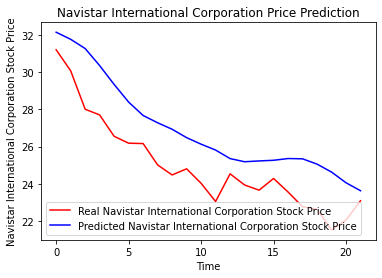

In [94]:
# Visualising the results

plt.plot(real_stock_price, color = 'red', label = 'Real Navistar International Corporation Stock Price')

plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Navistar International Corporation Stock Price')

plt.title('Navistar International Corporation Price Prediction')
plt.xlabel('Time')
plt.ylabel('Navistar International Corporation Stock Price')
plt.legend()

plt.show()

The blue line shows the trend of the stock for the month of January 2017. 

Some observations:
- The prediction lags behind the actual price curve because the model cannot react to fast non-linear changes. Spikes are examples of fast non-linear changes
- Model reacts pretty well to smooth changes

### Compute the RMSE

If we need to compute the RMSE for our Stock Price Prediction problem, we use the real stock price and predicted stock price as shown.

Then consider dividing this RMSE by the range of the Google Stock Price values of January 2017 to get a relative error, as opposed to an absolute error. 


In [87]:
#import the libraries
import math
from sklearn.metrics import mean_squared_error

In [93]:
rmse = math.sqrt( mean_squared_error( real_stock_price[0:22,:], predicted_stock_price))
rmse

2.112159882226059

## Improving the RNN

The new data need to be placed in the same order/format  as in the case of the training/test sets.

1. Getting more training data: we trained our model on the past 5 years of the  Google Stock Price but it would be even better to train it on the past 10 years.

2. Increasing the number of time steps: the model remembered the stock price from the 60 previous financial days to predict the stock price of the next day. That’s because we chose a number of 60 time steps (3 months). You could try to increase the number of time steps, by choosing for example 120 time steps (6 months).

3. Adding some other indicators: if you have the financial instinct that the stock price of some other companies might be correlated to the one of Google, you could add this other stock price as a new indicator in the training data.

4. Adding more LSTM layers: we built a RNN with four LSTM layers but you could try with even more.

5. Adding more neurons in the LSTM layers: we highlighted the fact that we needed a high number of neurons in the LSTM layers to respond better to the complexity of the problem and we chose to include 50 neurons in each of our 4 LSTM layers. You could try an architecture with even more neurons in each of the 4 (or more) LSTM layers.

### Fine tuning the RNN

Parameter Tuning on the RNN model: we are dealing with a Regression problem because we predict a continuous outcome.

**Tip**: replace: scoring = 'accuracy' by scoring = 'neg_mean_squared_error' in the GridSearchCV class parameters as we did in the ANN case.